<h1 style='text-align: center'>Análise e Previsão de Alugeis no Brasil</h1>

## Importações

In [1]:
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Carregando Base de Dados

In [2]:
# Carregando base de dados usando Spark
base = './dados/houses_to_rent_v2.csv'
df = spark.read.csv(base, header=True, inferSchema=False)

## Tratamento dos Dados

### Conhecendo a Base de Dados

Antes de iniciarmos as transformações, explorações e análises, é essencial que nos familiarizemos adequadamente com a base de dados. Isso proporcionará uma compreensão mais sólida do contexto e dos elementos-chave, permitindo-nos realizar as etapas subsequentes de maneira mais informada e eficaz.

#### Descrição dos dados do dataset:

1. **city**: Cidade onde o imóvel está localizado
2. **area**: Area do imovel
3. **rooms**: Número de quartos
4. **bathroom**: Número de banheiros
5. **parking spaces**: Número de vagas
6. **floor**: Andar
7. **animal**: Imovel aceita animais ou não
8. **furniture**: Imovel está mobiliado ou não
9. **hoa**: Valor do condominio
10. **rent amount**: Valor do aluguel
11. **property tax**: IPTU
12. **fire insurance**: Seguro incendio
13. **total**: Valor total

In [3]:
# visualizando as primeiras linhas
df.toPandas().head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [4]:
# visualizando as últimas linhas
df.toPandas().tail()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020
10691,São Paulo,80,2,1,0,-,acept,not furnished,0,1400,165,22,1587


In [5]:
def dimensao(dados):
    '''Retorna as dimensões do dataframe.'''
    print('Linhas:', dados.count())
    print('Colunas:', len(dados.columns))

In [6]:
# Dimensão do dataframe
dimensao(df)

Linhas: 10692
Colunas: 13


In [7]:
# Informações dos dados do dataset
df.printSchema()

root
 |-- city: string (nullable = true)
 |-- area: string (nullable = true)
 |-- rooms: string (nullable = true)
 |-- bathroom: string (nullable = true)
 |-- parking spaces: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- animal: string (nullable = true)
 |-- furniture: string (nullable = true)
 |-- hoa (R$): string (nullable = true)
 |-- rent amount (R$): string (nullable = true)
 |-- property tax (R$): string (nullable = true)
 |-- fire insurance (R$): string (nullable = true)
 |-- total (R$): string (nullable = true)



In [8]:
# Verificando valores faltantes ou nulos
for coluna in df.columns:
    print(coluna, df.filter(col(coluna).isNull()).count())

city 0
area 0
rooms 0
bathroom 0
parking spaces 0
floor 0
animal 0
furniture 0
hoa (R$) 0
rent amount (R$) 0
property tax (R$) 0
fire insurance (R$) 0
total (R$) 0


In [9]:
# Verificando quantidade de valores únicos de cada coluna
for coluna in df.columns:
    valores_unicos = df.select(countDistinct(col(coluna)).alias('count')).collect()[0]['count']
    print('coluna:',coluna,'-',valores_unicos)

coluna: city - 5
coluna: area - 517
coluna: rooms - 11
coluna: bathroom - 10
coluna: parking spaces - 11
coluna: floor - 35
coluna: animal - 2
coluna: furniture - 2
coluna: hoa (R$) - 1679
coluna: rent amount (R$) - 1195
coluna: property tax (R$) - 1243
coluna: fire insurance (R$) - 216
coluna: total (R$) - 5751


### Transformando a Base de Dados

Após uma análise inicial da base de dados, estamos prontos para iniciar o processo de tradução dos títulos das colunas, ajuste dos valores das variáveis, remoção de dados duplicados e modificação dos tipos de dados, incluindo a conversão entre strings, inteiros e floats conforme necessário.

In [10]:
# Alterando título das colunas do dataset
novo_titulo = [
    'cidade', 'area', 'quartos', 'banheiros', 'vagas', 'andar', 'animais',
    'mobilia', 'condominio', 'aluguel', 'iptu', 'seguro', 'total'
]
for indice, coluna in enumerate(df.columns):
    df = df.withColumnRenamed(coluna , novo_titulo[indice])

In [12]:
# Alterando atributo da coluna 'animal'
# not acept iremos alterar para 0
# acept iremos alterar para 1
df = df.withColumn('animais', when(col('animais') == 'not acept',0).otherwise(col('animais')))\
    .withColumn('animais', when(col('animais') == 'acept',1).otherwise(col('animais')))

# Alterando atributo da coluna 'mobilia'
# not furnished iremos alterar para 0
# furnished iremos alterar para 1
df = df.withColumn('mobilia', when(col('mobilia') == 'not furnished',0).otherwise(col('mobilia')))\
    .withColumn('mobilia', when(col('mobilia') == 'furnished',1).otherwise(col('mobilia')))

# Alterando valoe '-' para 0 na coluna andar
df = df.withColumn('andar', when(col('andar') == '-', 0).otherwise(col('andar')))

In [13]:
# Convertendo as colunas string em int
for coluna in df.columns[1:8]:
    df = df.withColumn(coluna, col(coluna).cast('int'))
    
for coluna in df.columns[8:]:
    df = df.withColumn(coluna, col(coluna).cast('float'))

In [14]:
# Verificando alteração
df.printSchema()

root
 |-- cidade: string (nullable = true)
 |-- area: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- vagas: integer (nullable = true)
 |-- andar: integer (nullable = true)
 |-- animais: integer (nullable = true)
 |-- mobilia: integer (nullable = true)
 |-- condominio: float (nullable = true)
 |-- aluguel: float (nullable = true)
 |-- iptu: float (nullable = true)
 |-- seguro: float (nullable = true)
 |-- total: float (nullable = true)



In [15]:
# Removendo registros duplicados
df = df.dropDuplicates()

In [16]:
# Visualizando base transformada
df.show(10)

+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+------+------+-------+
|        cidade|area|quartos|banheiros|vagas|andar|animais|mobilia|condominio|aluguel|  iptu|seguro|  total|
+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+------+------+-------+
|     São Paulo|  30|      1|        1|    0|    1|      1|      0|     460.0| 1600.0|   0.0|  21.0| 2081.0|
|Rio de Janeiro| 130|      3|        2|    1|    7|      1|      0|    1660.0| 1700.0| 475.0|  22.0| 3857.0|
|     São Paulo|  96|      3|        2|    2|   17|      1|      0|     804.0| 3200.0| 250.0|  41.0| 4295.0|
|Rio de Janeiro| 107|      3|        2|    0|    7|      1|      1|    1460.0| 3200.0| 270.0|  42.0| 4972.0|
|Rio de Janeiro| 105|      3|        2|    0|    1|      1|      0|     740.0| 2200.0|   9.0|  29.0| 2978.0|
|Belo Horizonte| 308|      2|        3|    3|    0|      1|      0|       0.0| 2000.0| 171.0|  33.0| 2204.0|
|     São Paulo| 48

In [17]:
# Dimensões do dataframe
dimensao(df)

Linhas: 10334
Colunas: 13


### Tratando Outliers

A fim de avançar nas análises, é imperativo assegurar a consistência dos dados. Para alcançar esse objetivo, faremos uma análise para identificar a presença de outliers e, se necessário, implementaremos os devidos procedimentos de tratamento.

In [18]:
def estatisticas(dados):
    '''Calcula e retorna a estatística descritiva da base de dados.'''
    summary = pd.DataFrame()
    for coluna in dados.columns[1:]:
        temp_df = dados.select(coluna).summary('min', '25%', '50%', '75%', 'max').toPandas()
        summary = pd.concat([summary, temp_df], axis=1)
    summary = summary.loc[:,~summary.columns.duplicated()]
    summary.set_index('summary', inplace=True)

    return summary

In [19]:
# Estatística descritiva da base de dados
estatisticas(df)

,area,quartos,banheiros,vagas,andar,animais,mobilia,condominio,aluguel,iptu,seguro,total
summary,,,,,,,,,,,,
min,11,1,1,0,0,0,0,0.0,450.0,0.0,3.0,499.0
25%,59,2,1,1,1,1,0,180.0,1590.0,40.0,21.0,2115.0
50%,95,3,2,1,3,1,0,571.0,2750.0,130.0,37.0,3685.0
75%,190,3,3,2,8,1,0,1286.0,5000.0,389.0,70.0,6909.0
max,46335,13,10,12,301,1,1,1117000.0,45000.0,313700.0,677.0,1120000.0


Ao examinar a tabela de estatísticas descritivas do dataframe, torna-se evidente a presença de outliers, destacando-se especialmente nas variáveis área, andar, condomínio e IPTU. Será realizada uma análise abrangente de todas essas variáveis.

In [20]:
def boxplot(dados):
    '''A função irá plotar os gráficos boxplot para cada variável numérica.'''
    df_pandas = dados.toPandas()
    
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    sns.boxplot(x=df_pandas['area'], ax=axs[0,0])
    sns.boxplot(x=df_pandas['quartos'], ax=axs[0,1])
    sns.boxplot(x=df_pandas['banheiros'], ax=axs[0,2])
    sns.boxplot(x=df_pandas['vagas'], ax=axs[1,0])
    sns.boxplot(x=df_pandas['andar'], ax=axs[1,1])
    sns.boxplot(x=df_pandas['condominio'], ax=axs[1,2])
    sns.boxplot(x=df_pandas['aluguel'], ax=axs[2,0])
    sns.boxplot(x=df_pandas['iptu'], ax=axs[2,1])
    sns.boxplot(x=df_pandas['seguro'], ax=axs[2,2])
    
    plt.show()

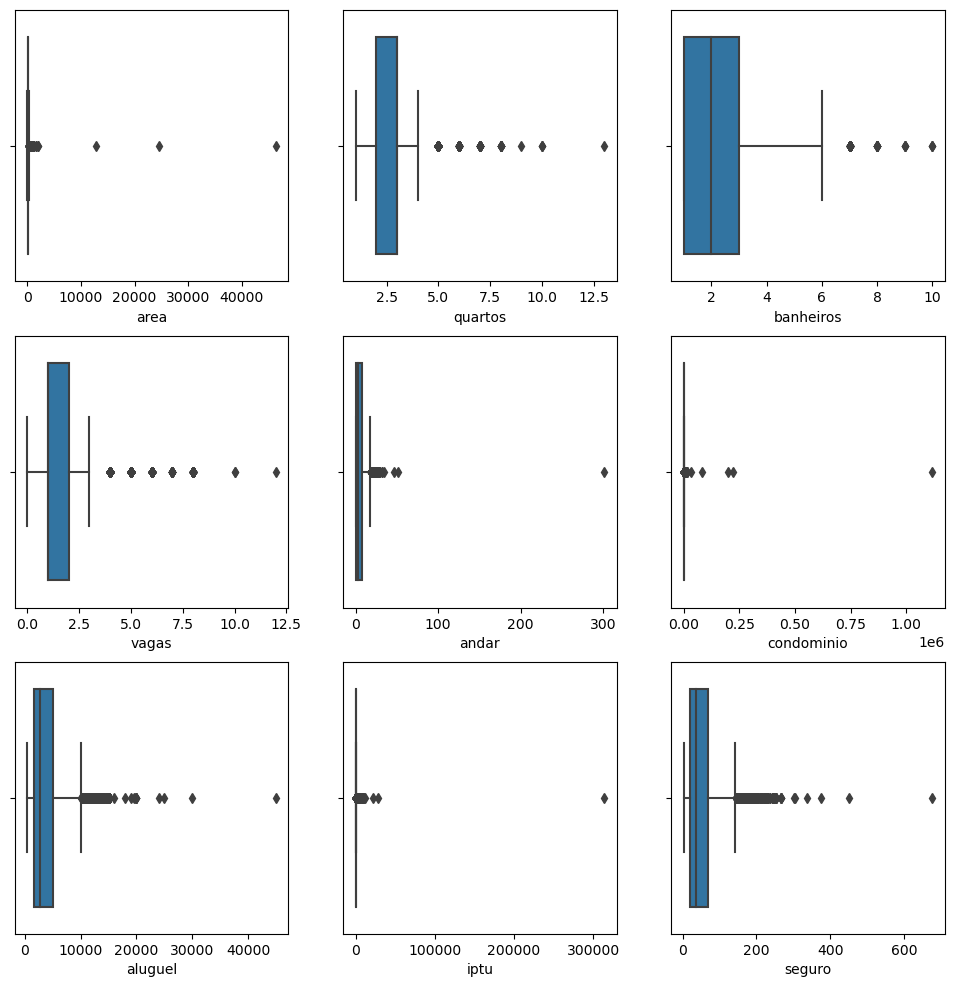

In [21]:
# Gerando gráficos boxplot para a visualização dos outliers
boxplot(df)

Ao examinar minuciosamente os gráficos boxplots, notamos a distorção provocada pelos outliers. Nesse contexto, planejamos abordar todos os valores que ultrapassam os limites superiores estabelecidos para cada coluna, visando uma correção mais precisa e robusta dos dados.

In [22]:
def upper_bound(dados, coluna):
    '''Retorna o valor o limite superior de cada coluna.'''
    quartis = dados.approxQuantile(coluna, [0.25,0.75],0.01)
    q1 = quartis[0]
    q3 = quartis[1]
    iqr = q3 - q1
    
    limite_superior = q3 + 1.5 * iqr
        
    return limite_superior

In [23]:
# Retorna os valores dos limites superiores de cada coluna
valores = []
for coluna in df.columns[1:]:
    valores.append(upper_bound(df, coluna))
    
print(valores)

[363.0, 4.5, 6.0, 3.5, 18.5, 1.0, 0.0, 2800.0, 10175.0, 877.5, 136.0, 13636.0]


In [24]:
# Removendo outliers apartir dos limites superiores de cada coluna
df_tratado = df.filter((col('area') <= 500) & (col('quartos') <= 5) & (col('banheiros') <= 6) & (col('vagas') <= 4)\
                      & (col('andar') <= 20) & (col('condominio') <= 2800.0) & (col('aluguel') <= 10175.0)\
                      & (col('iptu') <= 877.5) & (col('seguro') <= 136.0) & (col('total') <= 13636.0))

In [25]:
# Dimensões do dataframe
dimensao(df_tratado)

Linhas: 8308
Colunas: 13


In [26]:
# Estatística do dataframe tratado
estatisticas(df_tratado)

,area,quartos,banheiros,vagas,andar,animais,mobilia,condominio,aluguel,iptu,seguro,total
summary,,,,,,,,,,,,
min,11,1,1,0,0,0,0,0.0,450.0,0.0,3.0,499.0
25%,52,1,1,0,1,1,0,227.0,1400.0,27.0,19.0,1881.0
50%,78,2,2,1,3,1,0,530.0,2230.0,94.0,30.0,3016.0
75%,130,3,2,2,8,1,0,1000.0,3550.0,234.0,49.0,4835.0
max,500,5,6,4,20,1,1,2800.0,10140.0,876.0,136.0,13490.0


Agora, após realizar o devido tratamento no dataframe, torna-se possível identificar uma simetria nos dados ao examinar a tabela de estatísticas descritivas. Essa abordagem refinada nos permite obter insights mais precisos sobre a distribuição e a estrutura dos dados.

**Salvando Dataframe tratado**

In [27]:
df_tratado.toPandas().to_csv('./dados/house_to_rent_tratado.csv')

## Análise Exploratória dos Dados

In [28]:
# Carregando dataset tratado
base = './dados/house_to_rent_tratado.csv'
df = spark.read.csv(base, header=True, inferSchema=False)

# Visualizando o dataframe
df.show(5)

+---+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
|_c0|        cidade|area|quartos|banheiros|vagas|andar|animais|mobilia|condominio|aluguel| iptu|seguro| total|
+---+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
|  0|     São Paulo|  30|      1|        1|    0|    1|      1|      0|     460.0| 1600.0|  0.0|  21.0|2081.0|
|  1|Rio de Janeiro| 130|      3|        2|    1|    7|      1|      0|    1660.0| 1700.0|475.0|  22.0|3857.0|
|  2|     São Paulo|  96|      3|        2|    2|   17|      1|      0|     804.0| 3200.0|250.0|  41.0|4295.0|
|  3|Rio de Janeiro| 107|      3|        2|    0|    7|      1|      1|    1460.0| 3200.0|270.0|  42.0|4972.0|
|  4|Rio de Janeiro| 105|      3|        2|    0|    1|      1|      0|     740.0| 2200.0|  9.0|  29.0|2978.0|
+---+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
o

In [29]:
# Dimensões do dataframe
dimensao(df)

Linhas: 8308
Colunas: 14
